In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from decomposer import Decomposer
from scipy.optimize import minimize

from warnings import simplefilter
simplefilter('ignore')

In [2]:
df = pd.read_csv('gdp.csv', sep=';')
branches = ['Cp', 'Gp', 'Jp', 'Exp', 'Imp']

In [3]:
# инициализировать модель
decomposer = Decomposer(df, branches, n_components=3)
# обучить модель с регуляризацией, сделать 10 мультистартов и выбрать лучший
decomposer.fit(multistarts=15, reg=0.1, loss_function='mse')
# обучить модель без регуляризации, инициализируя текущими значениями
decomposer.fit(multistarts=5, reg=0, x0=decomposer, loss_function='mse')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

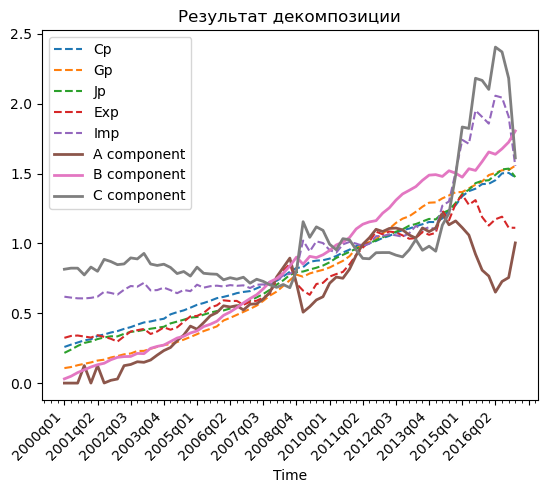

In [4]:
ax = df[branches].plot(linestyle='--')
sns.lineplot(x=df.t, y=decomposer.first_component,  label='A component',
             linewidth=2, ax=ax)
sns.lineplot(x=df.t, y=decomposer.second_component,  label='B component',
             linewidth=2, ax=ax)
if len(decomposer.components) > 2:
    sns.lineplot(x=df.t, y=decomposer.third_component,  label='C component', linewidth=2, ax=ax)
if len(decomposer.components) > 3: 
    sns.lineplot(x=df.t, y=decomposer.components[3],  label='D component', linewidth=2, ax=ax)
if len(decomposer.components) > 4:
    sns.lineplot(x=df.t, y=decomposer.components[4],  label='E component', linewidth=2, ax=ax)
ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Time")
plt.title("Результат декомпозиции"); 
# ax.figure.savefig('components.png', dpi=250)  # раскомментируйте, если хотите сохранить картинку

In [5]:
"""Вывод результатов разложения (alpha, rho)"""
decomposer.summary('ces').round(4)

,Cp,Gp,Jp,Exp,Imp
alpha_0,0.4096,0.0006,0.2897,0.8058,0.2082
alpha_1,0.3024,0.9518,0.4927,0.0033,0.1812
alpha_2,0.2880,0.0476,0.2176,0.1908,0.6105
rho,8.4610,7.0092,6.6941,3.0334,6.0360


In [6]:
"""Вывод метрик"""
decomposer.summary('errors').round(4)

,Cp,Gp,Jp,Exp,Imp
MSE,0.0012,0.0002,0.0003,0.0005,0.0002
MAPE,0.0414,0.0232,0.0191,0.0285,0.0106
MAE,0.0285,0.0107,0.0120,0.0171,0.0098


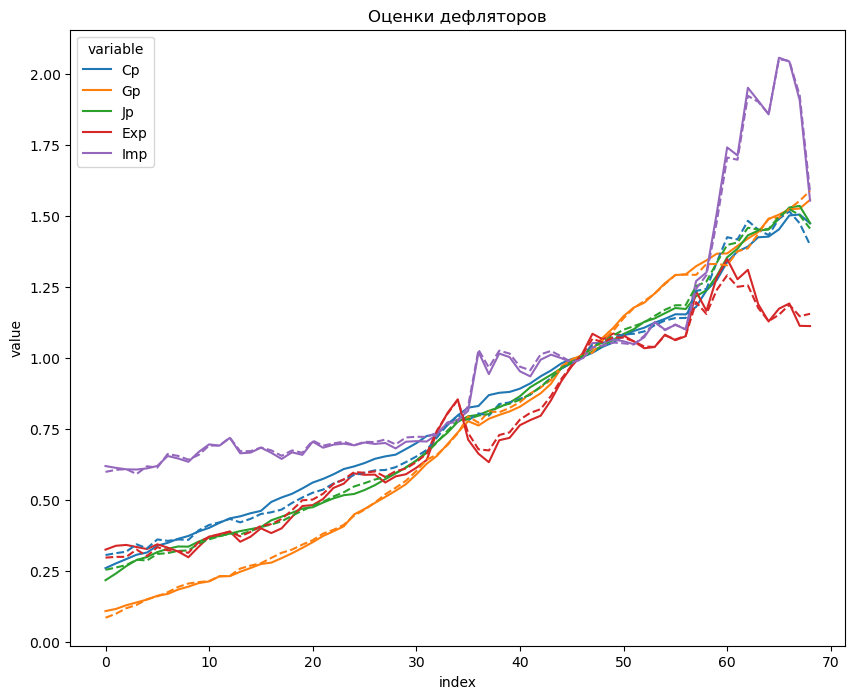

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(pd.melt(decomposer.targets.reset_index(), id_vars='index'), x='index', y='value', hue='variable')
sns.lineplot(pd.melt(decomposer.predictions.reset_index(), id_vars='index'),
             x='index', y='value', hue='variable', linestyle='--', legend=False)
plt.title("Оценки дефляторов")
ax.figure.savefig('preds.png', dpi=250)  # сохранить картинку

In [8]:
decomposer.save()
alpha, rho, components, base_coeffs, targets = [v for k, v in np.load('res.npz').items()]

### Попытка оценки объёмов компонент ВВП

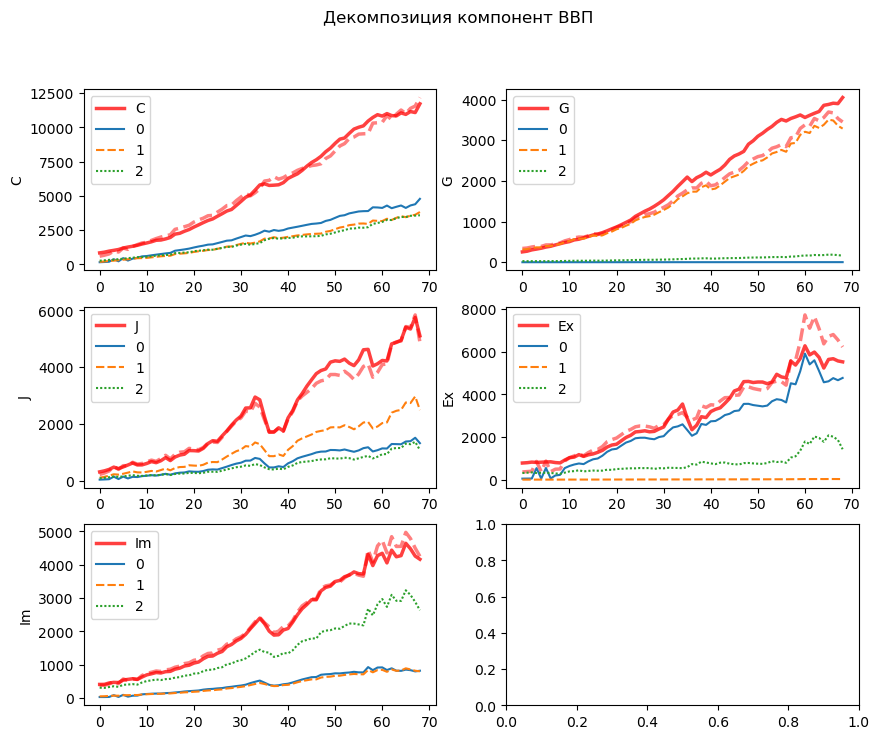

In [9]:
"""Вроде бы пока что работает не совсем праильно"""
X = df[[i[:-1] for i in decomposer.branches]].to_numpy()
res = decomposer.estimate_x(X)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
for k, branch in enumerate(branches):
    i, j = np.divmod(k, 2)
    sns.lineplot(df[branch[:-1]], ax=ax[i, j], color='red', label=branch[:-1], alpha=0.75, linewidth=2.5)
    sns.lineplot(res[:, k].T.sum(axis=1), ax=ax[i, j], color='red', linestyle='--', alpha=0.5, linewidth=2.5)
    sns.lineplot(res[:, k].T , ax=ax[i, j], linestyle='--')
plt.suptitle("Декомпозиция компонент ВВП");